# Introduction to dynamic time warping

Dynamic Time Warping is an algoritium for measuring similarity between two arrays (time, depth, etc.). This workflow is used commonly in audio analysis. It is also used for formation top picking in subsurface geological applications. There are a few different python imprementations, and we will go voer the various pro's and con's. The [wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping) article is a good read. 

We will be comparing 5 different DTW implementations:


1. librosa https://github.com/librosa/librosa
2. fastdtw https://github.com/slaypni/fastdtw
3. tslearn https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html
4. dtw-python https://github.com/DynamicTimeWarping/dtw-python
5. pydtw https://github.com/shunsukeaihara/pydtw

### Prerequisites

Intermedite level understanding of the numpy, pandas api is helpful. Most plots will be done using matplotlib.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns

import librosa
import librosa.display

from scipy.spatial.distance import cdist, euclidean

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%load_ext watermark
%watermark --iversions

seaborn   : 0.12.0
pandas    : 1.4.3
librosa   : 0.9.2
numpy     : 1.21.5
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
matplotlib: 3.5.2



# Creating Data

We will create our own dataset, using np sin. Some dynamic time warping methods can use multi-input

In [3]:
n = 8 # how many rounds of 360 do you want to do

degree_array = np.round(np.linspace(0, 360*n, num=int(360*n/2+1)), 2)
degree_array

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.876e+03, 2.878e+03,
       2.880e+03])

Let's make some noise:

In [4]:
noise =   np.random.normal(0, 0.075, len(degree_array))
noise1 =  np.random.normal(0, 0.1,  len(degree_array))
noise15 = np.random.normal(0, 0.25, len(degree_array))

# We will be using these noise variables later, they are put here for direct comparison
noise_a = np.random.normal(0,0.075,len(degree_array))
noise1_a = np.random.normal(0,0.1,len(degree_array))
noise15_a = np.random.normal(0,0.25,len(degree_array))

Sanity check, to make sure that noise and noise_a are not the same

In [5]:
np.max(noise - noise_a)

0.33891826528674995

In [6]:
baseline = np.sin(np.deg2rad(degree_array)) + noise
baseline25 = 2.5*np.sin(np.deg2rad(degree_array)) + noise1
baseline4 = 4*np.sin(np.deg2rad(degree_array)) + noise15

In [7]:
df = pd.DataFrame({'bline': baseline,
                  'bline25': baseline25,
                  'bline4': baseline4})

df.values

array([[ 0.04456492, -0.07546026,  0.01557775],
       [ 0.05390734, -0.0150291 , -0.0990168 ],
       [ 0.07078106,  0.25568453,  0.41278128],
       ...,
       [ 0.07401579, -0.17431712, -0.58693349],
       [-0.0013735 ,  0.07327821,  0.2820606 ],
       [ 0.07013253, -0.09367639,  0.36724934]])

(0.0, 360.0)

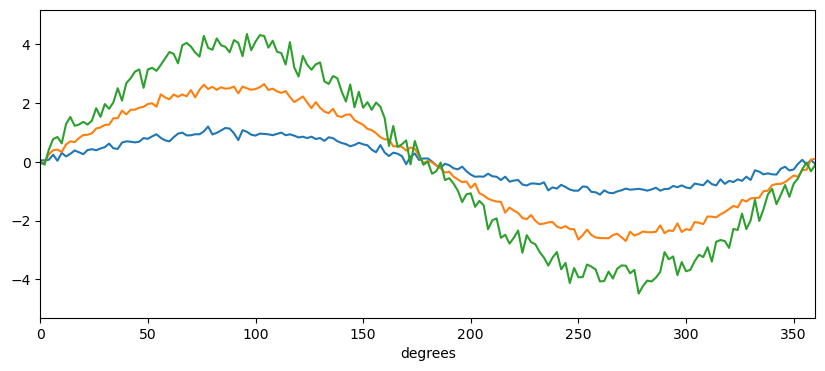

In [8]:
plt.figure(figsize=(10,4))

plt.plot(degree_array, df.values)
plt.xlabel('degrees')
plt.xlim(0, 360)

## Let's create another dataset to compare it too, with the same overall signal, but different noise

In [9]:
baseline_a = np.sin(np.deg2rad(degree_array)) + noise_a
baseline25_a = 2.5*np.sin(np.deg2rad(degree_array)) + noise1_a
baseline4_a = 4*np.sin(np.deg2rad(degree_array)) + noise15_a

In [10]:
df_a = pd.DataFrame({'bline_a': baseline_a,
                  'bline25_a': baseline25_a,
                  'bline4_A': baseline4_a})

(0.0, 300.0)

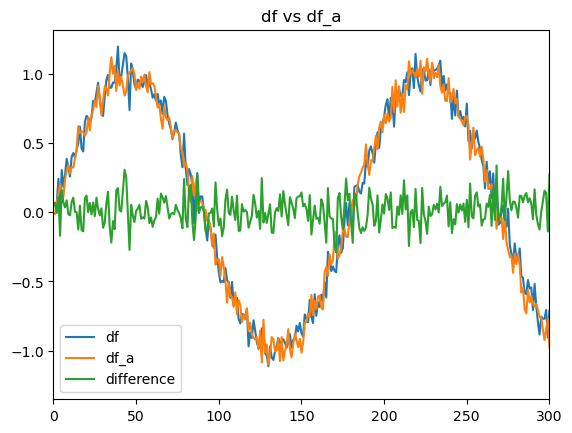

In [11]:
plt.plot(df.bline, label='df')
plt.plot(df_a.bline_a, label='df_a')
plt.plot(df.bline - df_a.bline_a, label='difference')
plt.legend()
plt.title('df vs df_a')
plt.xlim(0,300)

# Doing the timewarp!

We will start with the package librosa

D is the cost matrix

wp is the warping path

In [12]:
# various parameters

low_index = 180
high_index = 700
offset = 35

In [13]:
x = df[low_index:high_index:4].T.values
y = df_a[low_index+offset:high_index+offset:5].T.values

In [14]:
D, wp, steps = librosa.sequence.dtw(
                            X=x, # first dataframe
                            Y=y, # second dataframe
                            metric='cosine',
                            return_steps=True) 


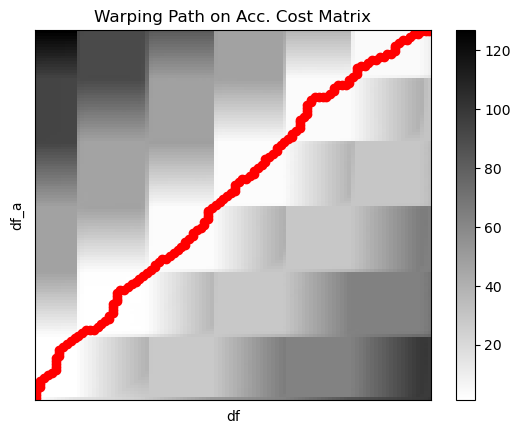

In [15]:
fig, ax = plt.subplots()
img = librosa.display.specshow(
                            D, 
                            cmap='gray_r', 
                            ax=ax)

ax.plot(wp[:, 1], wp[:, 0], marker='o', color='r')

ax.set(title='Warping Path on Acc. Cost Matrix', xlabel='df', ylabel='df_a')
       
fig.colorbar(img, ax=ax)

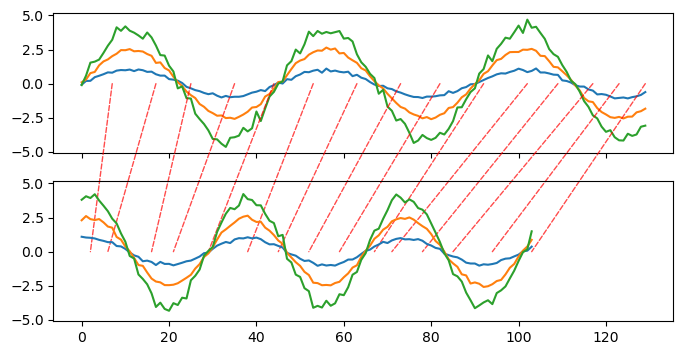

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 4))

# Plot x_2
ax1.plot(x.T)

# Plot x_1
ax2.plot(y.T)

n_arrows = 14

for tp1, tp2 in wp[::len(wp)//n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, 
                          axesB=ax2,
                          coordsA='data', 
                          coordsB='data',
                          color='r', 
                          linestyle='--',
                          alpha=0.7)
    ax2.add_artist(con)

# There are a few other options for DTW

Rubric to be graded on:
1. Multi - input possible (like above)
2. Release / Updates since Jan 1, 2019. 
3. General ease of use

#### Sanity check on x and y

In [17]:
print('x shape:', np.shape(x))
print('y shape:', np.shape(y))

x shape: (3, 130)
y shape: (3, 104)


## tslearn

tslearn has a few options that look really neat. 

In [18]:
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path

dtw_score = dtw(x, y)

path, sim = dtw_path(x, y)

/var/folders/mv/8ltb3p0j0wv_rnz_fytclgxc0000gq/T/ipykernel_2562/3464359606.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


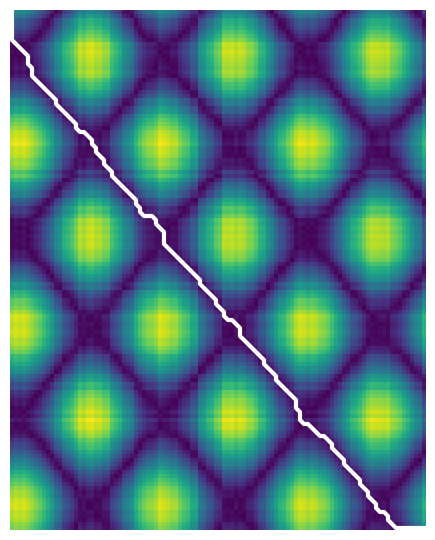

In [19]:
s_y1 =   x.T #np.concatenate((s_x, s_x)).reshape((-1, 1))
s_y2 =  y.T #np.concatenate((s_x, s_x[::-1])).reshape((-1, 1))
sz = s_y1.shape[0]

path, sim = metrics.dtw_path(s_y1, s_y2)

plt.figure(figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02


rect_gram = [left_h, bottom, width, height]

ax_gram = plt.axes(rect_gram)

mat = cdist(s_y1, s_y2)

ax_gram.imshow(mat)
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

plt.tight_layout()
plt.show()

Soft DTW: modified from this example: https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_softdtw_path.html#sphx-glr-auto-examples-metrics-plot-softdtw-path-py

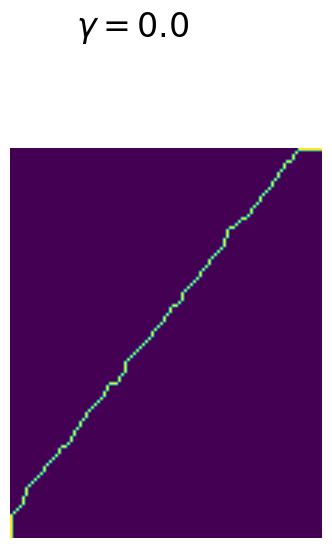

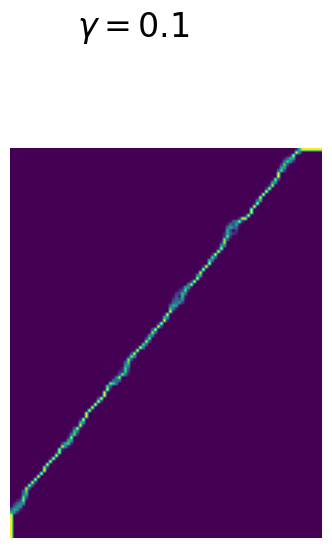

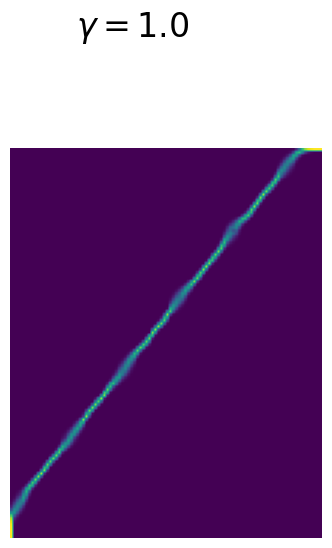

In [20]:
for gamma in [0., .1, 1.]:
    alignment, sim = metrics.soft_dtw_alignment(s_y1, s_y2, gamma=gamma)

    plt.figure(figsize=(6, 6))

    # definitions for the axes
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02

   
    rect_gram = [left_h, bottom, width, height]


    ax_gram = plt.axes(rect_gram)

    mat = cdist(s_y1, s_y2)

    ax_gram.imshow(alignment, origin='lower')
    ax_gram.axis("off")
    ax_gram.autoscale(False)
    plt.suptitle("$\\gamma={:.1f}$".format(gamma), fontsize=24)

    plt.show()

## pydtw

In [21]:
from pydtw import dtw2d

This is a necessary step, kinda picky:

In [22]:
_x = np.moveaxis(x, 0, 1).copy(order='C')
_y = np.moveaxis(y, 0, 1).copy(order='C')

In [23]:
cost_matrix, cost, alignmend_a, alignmend_b = dtw2d(_x, _y)

In [24]:
path_multi = np.array(list(zip(alignmend_a, alignmend_b)))
path_multi.shape

(133, 2)

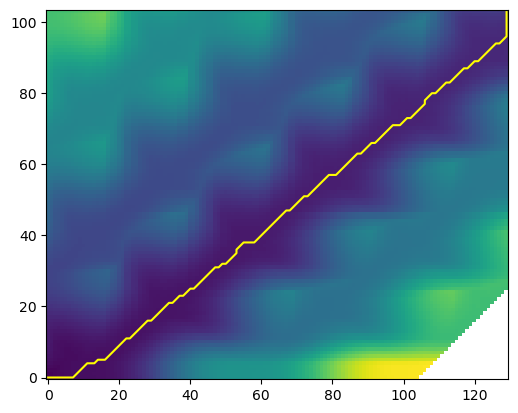

In [25]:

plt.imshow(cost_matrix.T, origin='lower')
plt.plot(*path_multi.T, color=(1,1,0))

# Fastdtw

In [26]:
from fastdtw import fastdtw

In [27]:
distance, path = fastdtw(x.T, y.T, dist=euclidean)
print(distance)

76.12821151864999


In [28]:
path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 1),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (10, 3),
 (11, 4),
 (12, 4),
 (13, 4),
 (14, 5),
 (15, 5),
 (16, 5),
 (17, 6),
 (18, 7),
 (19, 8),
 (20, 9),
 (21, 10),
 (22, 11),
 (23, 11),
 (24, 12),
 (25, 13),
 (26, 14),
 (27, 15),
 (28, 16),
 (29, 16),
 (30, 17),
 (31, 18),
 (32, 19),
 (33, 20),
 (34, 21),
 (35, 21),
 (36, 22),
 (37, 23),
 (38, 23),
 (39, 24),
 (40, 25),
 (41, 25),
 (42, 26),
 (43, 27),
 (44, 28),
 (45, 29),
 (46, 30),
 (47, 31),
 (48, 31),
 (49, 32),
 (50, 32),
 (51, 33),
 (52, 34),
 (53, 35),
 (53, 36),
 (54, 37),
 (55, 38),
 (56, 38),
 (57, 38),
 (58, 38),
 (59, 39),
 (60, 40),
 (61, 41),
 (62, 42),
 (63, 43),
 (64, 44),
 (65, 45),
 (66, 46),
 (67, 47),
 (68, 47),
 (69, 48),
 (70, 49),
 (71, 50),
 (72, 51),
 (73, 51),
 (74, 52),
 (75, 53),
 (76, 54),
 (77, 55),
 (78, 56),
 (79, 57),
 (80, 57),
 (81, 57),
 (82, 58),
 (83, 59),
 (84, 60),
 (85, 61),
 (86, 62),
 (87, 63),
 (88, 63),
 (89, 64),
 (90, 65),
 (91, 66),
 (92, 66

# dtw-python

In [29]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [30]:
alignment = dtw(x.T, y.T, keep_internals=True)

<AxesSubplot:>

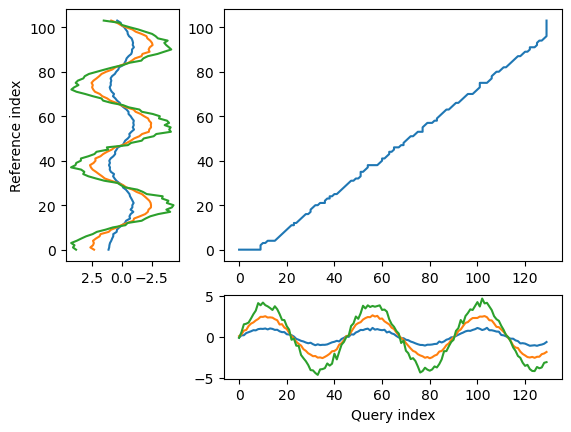

In [31]:
alignment.plot(type="threeway")

In [32]:
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

In [33]:
np.shape(template)

(100,)

Looks like the plot below works with 1 variable, but not multi-variable

<AxesSubplot:xlabel='Index', ylabel='Query value'>

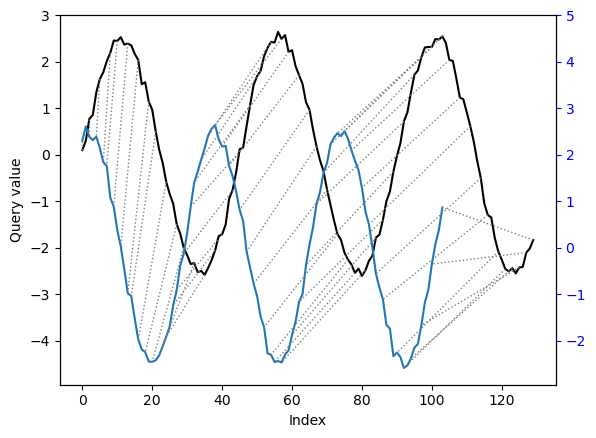

In [34]:
dtw(x.T[:, 1], y.T[:, 1], keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

# Review of options

tslearn, librosa, and pydtw, dtw-python all work out of the box, without too much fiddling for multi dimmensional, different length data. The librosa library was built for audio analysis, and has some nice time series tools. With many contributors, and a release within the last 6 months, this is one I would reccomend. tslearn had some great tools as well (soft DTW looks slick!). dtw-python has some great tools, and recent releases. Will need to do a deeper dive. pydtw is a much more focused package without some of the added functionality that the other packages have. 

 



fast dtw has not had an update in a while, and lacks some added functionality. Would not use for current or future projects.